In [1]:
!pip install tensorflow
!pip install opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 522.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 27.5 MB/s eta 0:00:00


In [2]:
# Standard
import os
import zipfile
from pathlib import Path
from tqdm import tqdm
import warnings

# Data
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Image
import cv2
from PIL import Image

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, classification_report

# Persistence
import joblib

# Suppress warnings
warnings.filterwarnings("ignore")


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammedomran","key":"2511695bcb020429c7a82888f38dccb3"}'}

In [4]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Step 1: Download ZIP to disk (not RAM)
!kaggle competitions download -c human-protein-atlas-image-classification

In [6]:
import zipfile
import os

# Unzip all downloaded files
for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall()


In [7]:
# List all files in the current directory
!ls

human-protein-atlas-image-classification.zip  sample_submission.csv  train.csv
kaggle.json				      test
sample_data				      train


In [8]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import matplotlib.image as img

import cv2

import os

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [9]:
# Count how many images are in each folder
print("Total train images:", len(os.listdir("train")))
print("Total test images:", len(os.listdir("test")))


Total train images: 124288
Total test images: 46808


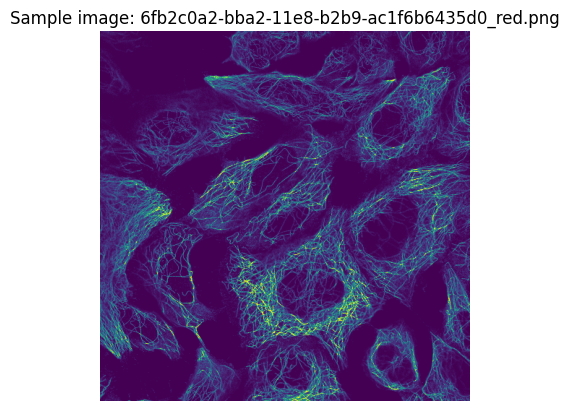

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and show one training image
img_path = os.path.join("train", os.listdir("train")[0])
img = mpimg.imread(img_path)

plt.imshow(img)
plt.title(f"Sample image: {os.path.basename(img_path)}")
plt.axis('off')
plt.show()

In [11]:
import pandas as pd
# first load the training labels
train_labels = pd.read_csv("train.csv")
train_labels.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [12]:
# courtesy of https://www.kaggle.com/code/allunia/protein-atlas-exploration-and-baseline
label_names = {
    0:  "Nucleoplasm",
    1:  "Nuclear membrane",
    2:  "Nucleoli",
    3:  "Nucleoli fibrillar center",
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",
    6:  "Endoplasmic reticulum",
    7:  "Golgi apparatus",
    8:  "Peroxisomes",
    9:  "Endosomes",
    10:  "Lysosomes",
    11:  "Intermediate filaments",
    12:  "Actin filaments",
    13:  "Focal adhesion sites",
    14:  "Microtubules",
    15:  "Microtubule ends",
    16:  "Cytokinetic bridge",
    17:  "Mitotic spindle",
    18:  "Microtubule organizing center",
    19:  "Centrosome",
    20:  "Lipid droplets",
    21:  "Plasma membrane",
    22:  "Cell junctions",
    23:  "Mitochondria",
    24:  "Aggresome",
    25:  "Cytosol",
    26:  "Cytoplasmic bodies",
    27:  "Rods & rings"
}

reverse_train_labels = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    # Only split if it's a string
    if isinstance(row.Target, str):
        targets = np.array(row.Target.split(" ")).astype(int)
    else:
        targets = row.Target  # Already an array from previous processing

    for num in targets:
        name = label_names[int(num)]
        row.loc[name] = 1
    row.Target = targets  # Keep consistent format
    return row


In [13]:
# add column for each protein and set to 0
for key in label_names.keys():
    train_labels[label_names[key]] = 0
# for each target value, set corresponding column = 1
train_labels = train_labels.apply(fill_targets, axis=1)
train_labels.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [14]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31072 entries, 0 to 31071
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Id                             31072 non-null  object
 1   Target                         31072 non-null  object
 2   Nucleoplasm                    31072 non-null  int64 
 3   Nuclear membrane               31072 non-null  int64 
 4   Nucleoli                       31072 non-null  int64 
 5   Nucleoli fibrillar center      31072 non-null  int64 
 6   Nuclear speckles               31072 non-null  int64 
 7   Nuclear bodies                 31072 non-null  int64 
 8   Endoplasmic reticulum          31072 non-null  int64 
 9   Golgi apparatus                31072 non-null  int64 
 10  Peroxisomes                    31072 non-null  int64 
 11  Endosomes                      31072 non-null  int64 
 12  Lysosomes                      31072 non-null  int64 
 13  I

In [15]:
train_labels.describe()

,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Peroxisomes,Endosomes,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
count,31072.000000,31072.000000,31072.000000,31072.000000,31072.000000,31072.000000,31072.000000,31072.000000,31072.000000,31072.000000,...,31072.000000,31072.000000,31072.000000,31072.000000,31072.000000,31072.000000,31072.000000,31072.000000,31072.000000,31072.000000
mean,0.414682,0.040358,0.116536,0.050238,0.059797,0.080877,0.032441,0.090821,0.001706,0.001448,...,0.029029,0.047696,0.005536,0.121556,0.025811,0.095424,0.010363,0.264804,0.010556,0.000354
std,0.492675,0.196800,0.320871,0.218440,0.237113,0.272650,0.177171,0.287359,0.041266,0.038029,...,0.167891,0.213125,0.074196,0.326778,0.158574,0.293804,0.101272,0.441236,0.102201,0.018812
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# Drop non-label columns and sum each label column
label_counts = train_labels.drop(columns=["Id", "Target"]).sum().sort_values(ascending=False)

# Convert to a DataFrame for nice formatting
label_counts_df = label_counts.reset_index()
label_counts_df.columns = ["Label", "Count"]

# Display top counts
print(label_counts_df)


                            Label  Count
0                     Nucleoplasm  12885
1                         Cytosol   8228
2                 Plasma membrane   3777
3                        Nucleoli   3621
4                    Mitochondria   2965
5                 Golgi apparatus   2822
6                  Nuclear bodies   2513
7                Nuclear speckles   1858
8       Nucleoli fibrillar center   1561
9                      Centrosome   1482
10               Nuclear membrane   1254
11         Intermediate filaments   1093
12                   Microtubules   1066
13          Endoplasmic reticulum   1008
14  Microtubule organizing center    902
15                 Cell junctions    802
16                Actin filaments    688
17           Focal adhesion sites    537
18             Cytokinetic bridge    530
19             Cytoplasmic bodies    328
20                      Aggresome    322
21                Mitotic spindle    210
22                 Lipid droplets    172
23              

In [17]:
import plotly.express as px

fig = px.bar(label_counts_df,
             x="Label",
             y="Count",
             title="Label Frequency in Training Data",
             labels={"Count": "Number of Images"})

fig.update_layout(
    xaxis_tickangle=-90,
    xaxis_title="Label",
    yaxis_title="Number of Images",
    plot_bgcolor='white',
    yaxis_gridcolor='lightgray',
    yaxis_gridwidth=1,
    yaxis_showgrid=True,
    margin=dict(l=20, r=20, t=40, b=100)  # Adjust margins for better label display
)

fig.show()

In [18]:
import plotly.express as px

# Calculate without modifying original DataFrame
target_counts = train_labels.drop(["Id", "Target"], axis=1).sum(axis=1)

# Convert to percentage
count_perc = np.round(100 * target_counts.value_counts() / len(target_counts), 2)

# Create Plotly bar chart
fig = px.bar(
    x=count_perc.index.values,
    y=count_perc.values,
    color=count_perc.index.values,
    color_continuous_scale="Reds",
    labels={'x': 'Number of targets per image', 'y': '% of train data'},
    title='Distribution of Multiple Targets in Images'
)

# Update layout
fig.update_layout(
    xaxis_title="Number of targets per image",
    yaxis_title="% of train data",
    plot_bgcolor='white',
    showlegend=False,
    margin=dict(l=50, r=50, t=80, b=50),
    coloraxis_showscale=False
)

fig.update_xaxes(type='category')
fig.show()

In [19]:
import plotly.graph_objects as go

# Create filtered dataframe (multiple targets only) and calculate correlations
corr_df = train_labels.drop(
    ["Id", "Target"], axis=1
).corr()

# Create Plotly heatmap
fig = go.Figure(go.Heatmap(
    z=corr_df.values,
    x=corr_df.columns,
    y=corr_df.columns,
    colorscale='icefire',
    zmin=-1,
    zmax=1,
    colorbar=dict(title='Correlation')
))

# Update layout for better readability
fig.update_layout(
    title='Correlation Heatmap (Images with Multiple Targets)',
    width=800,
    height=800,
    xaxis=dict(tickangle=-45),
    yaxis=dict(autorange='reversed'),  # Match Seaborn's style
    margin=dict(l=100, r=100, t=100, b=100)
)
fig.show()

In [20]:
from dataclasses import dataclass

In [21]:
@dataclass
class Config:
    image_dir: Path = Path("/content/train")
    label_csv: Path = Path("/content/train.csv")
    image_shape: tuple = (32, 32)  # ↓ Smaller size for faster processing
    channels: list = ('red', 'green', 'blue', 'yellow')
    validation_split: float = 0.2
    cache_file: Path = Path("features_cache.npz")
    pca_file: Path = Path("pca_model.pkl")
    n_components_pca: int = 300
    use_small_sample: bool = True
    sample_size: int = 24858  # Train on a small subset for dev

CONFIG = Config()


In [22]:
def load_image(image_id: str, config=CONFIG) -> np.ndarray:
    try:
        stacked = []
        for c in config.channels:
            path = config.image_dir / f"{image_id}_{c}.png"
            if not path.exists():
                raise FileNotFoundError(f"Missing: {path}")
            img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, config.image_shape)
            stacked.append(img_resized)
        return np.stack(stacked, axis=-1).flatten()
    except Exception as e:
        print(f"[Error] {image_id}: {e}")
        return None

In [23]:
from skimage.feature import hog
from skimage.color import rgb2gray

def extract_features(img):
    # Convert to grayscale from 4 channels (optional average)
    gray = np.mean(img.reshape(CONFIG.image_shape + (4,)), axis=-1)
    # HOG: Histogram of Oriented Gradients (can be tuned)
    hog_features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
    return hog_features


In [28]:
from sklearn.decomposition import PCA

In [30]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd
import numpy as np
from PIL import Image
import os
from tqdm import tqdm

# --- Config ---
class Config:
    image_dir = "data/train"
    csv_path = "data/train.csv"
    image_shape = (512, 512)
    batch_size = 64
    num_workers = 2
    num_classes = 28

CONFIG = Config()

# --- Utilities ---
def load_image(image_id, config):
    colors = ["red", "green", "blue", "yellow"]
    imgs = [Image.open(os.path.join(config.image_dir, f"{image_id}_{c}.png")).resize((32, 32)) for c in colors]
    merged = np.stack([np.array(imgs[i]) for i in range(3)], axis=-1)  # RGB only
    return merged

class HPAProteinDataset(Dataset):
    def __init__(self, df, config, transform=None):
        self.df = df
        self.config = config
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row.Id
        img = load_image(image_id, self.config).astype(np.uint8)
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        label = int(str(row.Target).split()[0])  # Use only the first label for now
        return img, label

# --- Transform ---
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# --- Dataset ---
df_train = pd.read_csv(CONFIG.csv_path)
dataset = HPAProteinDataset(df_train, CONFIG, transform)
loader = DataLoader(dataset, batch_size=CONFIG.batch_size, shuffle=True, num_workers=CONFIG.num_workers)

# --- FeatureNet CNN ---
class FeatureNet(nn.Module):
    def __init__(self, output_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.flat = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(32 * 8 * 8, output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flat(x)
        x = self.fc(x)
        return x

# --- CNN Training ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_net = FeatureNet().to(device)

class DummyClassifier(nn.Module):
    def __init__(self, feature_net, num_classes):
        super().__init__()
        self.feature_net = feature_net
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        feats = self.feature_net(x)
        return self.classifier(feats)

clf_model = DummyClassifier(feature_net, CONFIG.num_classes).to(device)
optimizer = torch.optim.Adam(clf_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

print("Training CNN...")
for epoch in range(10):
    clf_model.train()
    total_loss = 0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        outputs = clf_model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(loader):.4f}")

# --- Feature Extraction ---
def extract_features(dataloader, model):
    model.eval()
    feats, labels = [], []
    with torch.no_grad():
        for images, lbls in tqdm(dataloader):
            f = model(images.to(device)).cpu().numpy()
            feats.append(f)
            labels.append(lbls.numpy())
    return np.vstack(feats), np.concatenate(labels)

print("Extracting features from CNN...")
X_train, y_train = extract_features(loader, feature_net)

# --- Normalize and Train SVM ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

print("Training SVM...")
svm = OneVsRestClassifier(SVC(C=1, kernel="linear", probability=True))
svm.fit(X_train, y_train)
print("Done.")


100%|██████████| 170M/170M [00:02<00:00, 74.0MB/s]


Training CNN...
Epoch 1, Loss: 1.7127
Epoch 2, Loss: 1.4320
Epoch 3, Loss: 1.3021
Epoch 4, Loss: 1.2119
Epoch 5, Loss: 1.1391
Epoch 6, Loss: 1.0882
Epoch 7, Loss: 1.0448
Epoch 8, Loss: 1.0091
Epoch 9, Loss: 0.9892
Epoch 10, Loss: 0.9634
Epoch 11, Loss: 0.9438
Epoch 12, Loss: 0.9289
Epoch 13, Loss: 0.9132
Epoch 14, Loss: 0.8982
Epoch 15, Loss: 0.8889
Epoch 16, Loss: 0.8795
Epoch 17, Loss: 0.8708
Epoch 18, Loss: 0.8596
Epoch 19, Loss: 0.8517
Epoch 20, Loss: 0.8335
Extracting features...
Training SVM with GridSearchCV...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best C: 0.1
SVM Accuracy: 0.7364
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.79      0.76      1000
           1       0.82      0.88      0.85      1000
           2       0.63      0.64      0.63      1000
           3       0.56      0.52      0.54      1000
           4       0.73      0.67      0.70      1000
           5       0.64      0.

In [ ]:
# --- Config continues ---
class TestConfig:
    test_dir = "data/test"
    output_csv = "submission.csv"
    image_shape = (32, 32)
    batch_size = 64

# --- Submission Dataset ---
class HPATestDataset(Dataset):
    def __init__(self, image_ids, config, transform=None):
        self.image_ids = image_ids
        self.config = config
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img = load_image(image_id, config=CONFIG).astype(np.uint8)
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, image_id

# --- Load test image IDs ---
test_image_ids = [f.split("_")[0] for f in os.listdir(TestConfig.test_dir) if f.endswith("_green.png")]
test_image_ids = sorted(list(set(test_image_ids)))

test_dataset = HPATestDataset(test_image_ids, CONFIG, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=TestConfig.batch_size, shuffle=False)

# --- Extract test features ---
print("Extracting test features...")
feature_net.eval()
test_features = []
image_ids = []

with torch.no_grad():
    for imgs, ids in tqdm(test_loader):
        feats = feature_net(imgs.to(device)).cpu().numpy()
        test_features.append(feats)
        image_ids.extend(ids)

X_test = np.vstack(test_features)
X_test = scaler.transform(X_test)

# --- Predict using trained SVM ---
print("Predicting test labels...")
test_preds = svm.predict(X_test)

# --- Format submission: one label per test image ---
submission = pd.DataFrame({
    "Id": image_ids,
    "Predicted": [str(label) for label in test_preds]
})

# --- Save to CSV ---
submission.to_csv(TestConfig.output_csv, index=False)
print(f"Submission saved to {TestConfig.output_csv}")